# Import Modules

In [1]:
from fish_helpers import *
from MERFISH_Objects.FISHData import *
import anndata
import scanpy as sc
from sklearn.preprocessing import normalize

# Load Data

In [2]:
""" Measured Data """
data = anndata.read_h5ad('/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/results/clustered.h5ad')

In [3]:
data

AnnData object with n_obs × n_vars = 97786 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'stage_x', 'stage_y', 'leiden', 'opt_types'
    uns: 'leiden', 'neighbors'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors'
    obsp: 'connectivities', 'distances'

In [4]:
""" Reference Data """
ref_data = anndata.read_h5ad('/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/SmartSeq_dpnmf/anndata.h5ad')

In [5]:
ref_data

AnnData object with n_obs × n_vars = 74973 × 24
    obsm: 'Level_1_class_label', 'Level_2_neighborhood_label', 'Level_3_subclass_label', 'Level_4_supertype_label', 'Level_5_cluster_label', 'cell_type_accession_color', 'cell_type_accession_id', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_id', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_id', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_id', 'cell_type_designation_label', 'class_color', 'class_label', 'class_order', 'cluster_color', 'cluster_label', 'cluster_order', 'cortical_layer_label', 'donor_sex_label', 'exp_component_name', 'external_donor_name_color', 'external_donor_name_id', 'external_donor_name_label', 'facs_population_plan_color', 'facs_population_plan_id', 'facs_population_plan_label', 'full_genotype_color', 'full_genotype_id', 'full_genotype_label', 'injection_materials_color', 'injection_materials_id', 'injection_materials_label',

# Convert to Angular

In [6]:
data.layers['DPNMF'] = data.layers['total_vectors'].copy()
data.X = data.layers['total_vectors'].copy()
data = data[np.isnan(data.X.max(1))==False]
data.X = data.X/np.array(data.obs['total_signal'])[:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.layers['DPNMF_IQR'] = data.X.copy()
data.X = normalize(data.X)
data.layers['DPNMF_IQR_L2'] = data.X.copy()

In [7]:
ref_data.layers['DPNMF'] = ref_data.X.copy()
ref_data = ref_data[np.isnan(ref_data.X.max(1))==False]
ref_data.X = ref_data.X - np.array([np.percentile(ref_data.X[:,i],25) for i in range(ref_data.X.shape[1])])
ref_data.X = ref_data.X / np.array([np.percentile(ref_data.X[:,i],75) for i in range(ref_data.X.shape[1])])
ref_data.layers['DPNMF_IQR'] = ref_data.X.copy()
ref_data.X = normalize(ref_data.X)
ref_data.layers['DPNMF_IQR_L2'] = ref_data.X.copy()

# Harmonize

In [8]:
temp_data = data[data.layers['DPNMF_IQR'].max(1)!=0]
temp_ref_data = ref_data[ref_data.layers['DPNMF_IQR'].max(1)!=0]

In [9]:
""" Try Harmony Anchor Reference"""
merged_data = anndata.AnnData(X=np.concatenate([temp_data.layers['DPNMF_IQR'].astype(float),temp_ref_data.layers['DPNMF_IQR'].astype(float)]),
                              var=temp_data.var,
                              obs=pd.DataFrame(np.concatenate([np.array(temp_data.obs.index),np.array(temp_ref_data.obs.index)])))
merged_data.obs['dataset'] = np.concatenate([np.array(['a' for i in range(len(temp_data.obs))]),np.array(['b' for i in range(len(temp_ref_data.obs))])])
merged_data.obs['label'] = np.concatenate([np.array(['unknown' for i in range(len(temp_data.obs))]),np.array(temp_ref_data.obsm['Level_3_subclass_label'].astype(str))])
merged_data.obsm['DPNMF'] = merged_data.X.copy()
merged_data.layers['DPNMF'] = merged_data.X.copy()
merged_data.raw = merged_data

import scanpy.external as sce
sce.pp.harmony_integrate(merged_data, 'dataset',basis='DPNMF',adjusted_basis='DPNMF_harmony',reference_values='a')

temp_data.obsm['DPNMF_harmony'] = np.array(merged_data[merged_data.obs['dataset'] == 'a'].obsm['DPNMF_harmony'])
temp_ref_data.obsm['DPNMF_harmony'] = np.array(merged_data[merged_data.obs['dataset'] == 'b'].obsm['DPNMF_harmony'])

/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2021-11-29 14:06:54,641 - harmonypy - INFO - Iteration 1 of 10
2021-11-29 14:08:51,385 - harmonypy - INFO - Iteration 2 of 10
2021-11-29 14:10:46,031 - harmonypy - INFO - Iteration 3 of 10
2021-11-29 14:12:47,366 - harmonypy - INFO - Iteration 4 of 10
2021-11-29 14:14:58,100 - harmonypy - INFO - Iteration 5 of 10
2021-11-29 14:17:15,350 - harmonypy - INFO - Iteration 6 of 10
2021-11-29 14:19:34,552 - harmonypy - INFO - Iteration 7 of 10
2021-11-29 14:21:46,646 - harmonypy - INFO - Iteration 8 of 10
2021-11-29 14:23:56,547 - harmonypy - INFO - Iteration 9 of 10
2021-11-29 14:26:24,029 - harmonypy - INFO - Iteration 10 of 10
2021-11-29 14:28:29,157 - harmonypy - INFO - Stopped before convergence


# Classify Allen Data

## Build Classifier

In [10]:
""" Class Balance """
n_cells = 100
X = temp_data.obsm['DPNMF_harmony'].copy()
Y = np.array(temp_data.obs['opt_types'])
Y_unique = np.unique(Y)
X_balanced = []#np.zeros([Y_unique.shape[0]*n_cells,X.shape[1]])
Y_balanced = []
for y in tqdm(Y_unique):
    idx = np.where(Y==y)[0]
    if idx.shape[0]>n_cells:
        idx = np.random.choice(idx,n_cells,replace=False)
    else:
        idx = np.random.choice(idx,n_cells,replace=True)
    X_balanced.append(X[idx,:])
    Y_balanced.append(Y[idx])
X_balanced = np.concatenate(X_balanced)
Y_balanced = np.concatenate(Y_balanced)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 318.23it/s]


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = X_balanced# temp_data.obsm['DPNMF_harmony'].copy() #X_balanced
Y = Y_balanced#np.array(temp_data.obs['opt_types']) #Y_balanced
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
model =  KNeighborsClassifier(15,metric='correlation')
# model = MLPClassifier(max_iter=1000)
model.fit(X_train,y_train)

KNeighborsClassifier(metric='correlation', n_neighbors=15)

## Test Classifier

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [02:12<00:00,  1.56it/s]


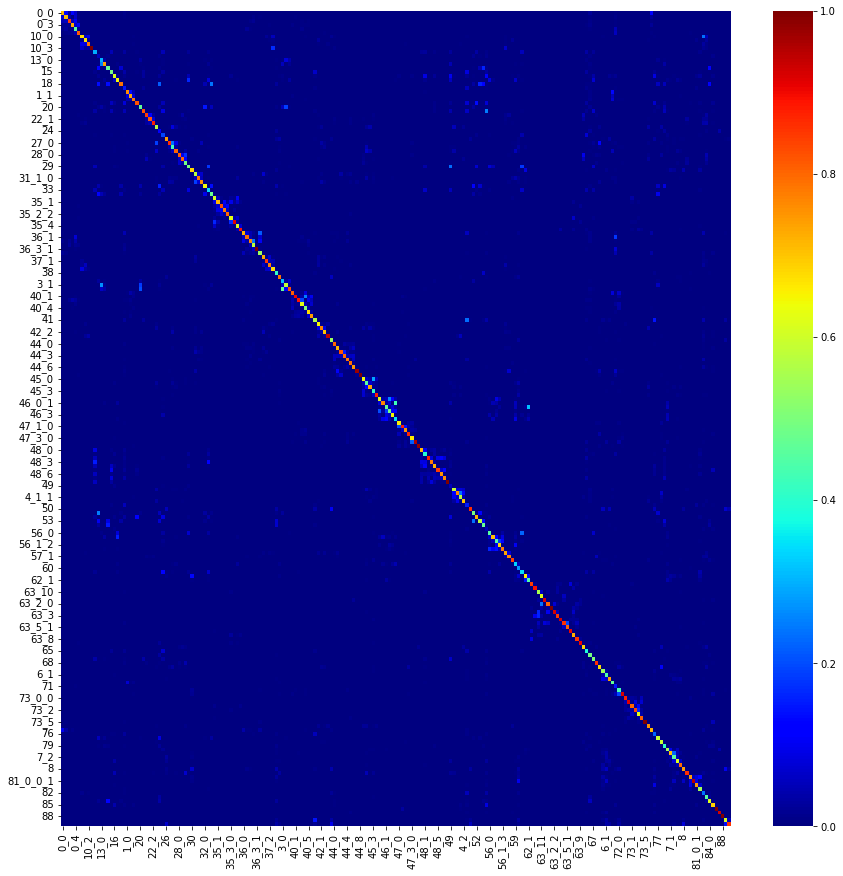

In [13]:
predictions = model.predict(temp_data.obsm['DPNMF_harmony'].copy())
# print(classification_report(y_test,predictions))
# predictions = model.predict(temp_ref_data.obsm['DPNMF_harmony'].copy())
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_data.obs['opt_types'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =predictions==i_label
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        cmat[i,j] = np.sum(i_mask&j_mask)
cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.heatmap(cmat,cmap='jet',vmin=0,vmax=1)

## Classify

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:20<00:00, 10.12it/s]


<Figure size 1080x1080 with 0 Axes>

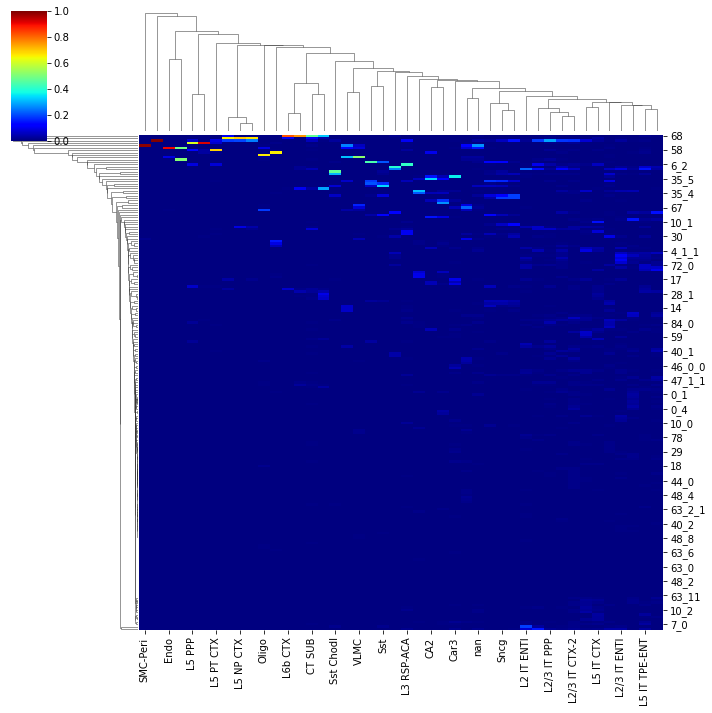

In [14]:
predictions = model.predict(temp_ref_data.obsm['DPNMF_harmony'].copy())
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_3_subclass_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =predictions==i_label
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        cmat[i,j] = np.sum(i_mask&j_mask)
cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='jet',vmin=0,vmax=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:38<00:00,  5.45it/s]
/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1080x1080 with 0 Axes>

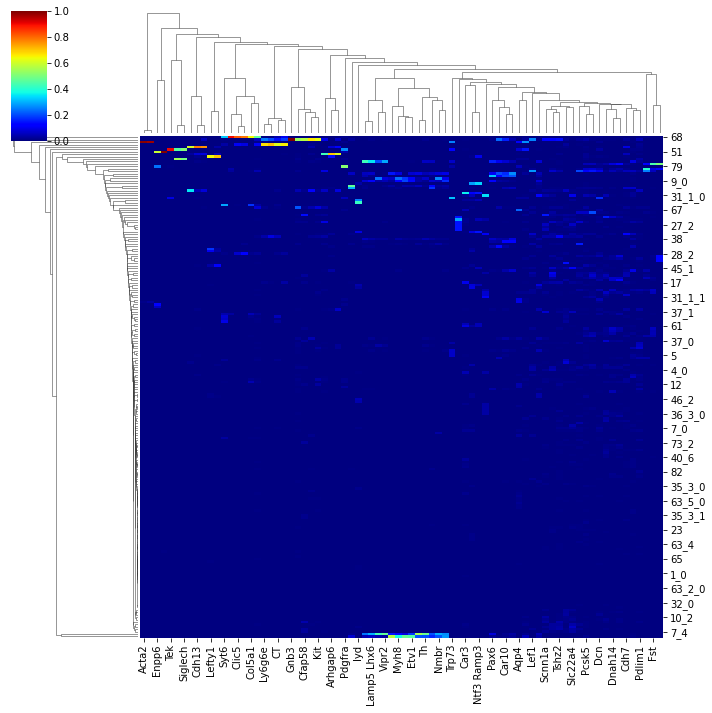

In [15]:
# predictions = model.predict(temp_ref_data.obsm['DPNMF_harmony'].copy())
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_4_supertype_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =predictions==i_label
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        cmat[i,j] = np.sum(i_mask&j_mask)
cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='jet',vmin=0,vmax=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [02:50<00:00,  1.21it/s]


<Figure size 1080x1080 with 0 Axes>

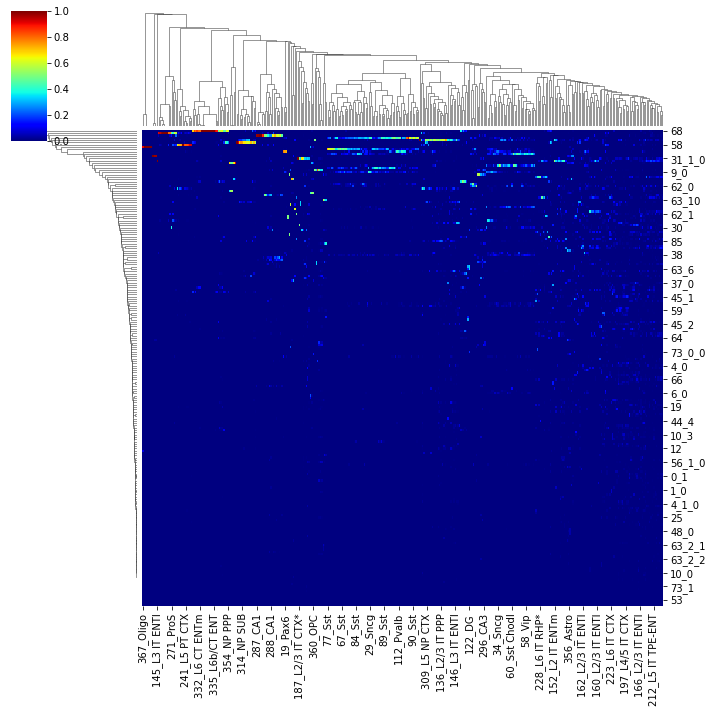

In [16]:
# predictions = model.predict(temp_ref_data.obsm['DPNMF_harmony'].copy())
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_5_cluster_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =predictions==i_label
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        cmat[i,j] = np.sum(i_mask&j_mask)
cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='jet',vmin=0,vmax=1)

# Classify Our Data Instead